<a href="https://colab.research.google.com/github/OsVox/YouTube-predictions/blob/main/YouTube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules and reading data

In [ ]:
!pip install pyyaml h5py -q
!pip install tensorflow_text -q
# !pip install keras.utils

In [ ]:
import os
import gc
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras
import torch
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import LSTM, Dense
from keras.utils.vis_utils import plot_model
# from transformers import BertTokenizer, BertModel, AutoTokenizer

from google.colab import drive
mount_directory = "/content/drive"

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(encoder_url)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
test = pd.read_parquet('/content/gdrive/MyDrive/youtube/data/test')
train = pd.read_parquet('/content/gdrive/MyDrive/youtube/data/little_train')

def save(what=train):
    what.to_parquet('/content/gdrive/MyDrive/youtube/data/little_train')

# Basic secription of data 

## filling null values

In [ ]:
dfs = [train, test]

In [ ]:
for df in dfs:
    df['has_description'] = ~df['description'].isnull()
    df.description.fillna('No description', inplace=True)
    df.trending_date = pd.to_datetime(df.trending_date)

## battle with outliers

In [ ]:
train['log_target'] = np.log(train.target)

In [ ]:
lower_bound = train.log_target.quantile(0.55) - 1.5 * (train.log_target.quantile(0.75) - train.log_target.quantile(0.25)) 
upper_bound = train.log_target.quantile(0.70) + 1.5 * (train.log_target.quantile(0.75) - train.log_target.quantile(0.25)) 
train = train[(train.log_target > lower_bound) & (train.log_target < upper_bound)].reset_index(drop=True)
save()

# Using BERT to deal with titles, descriptions and tags

## Making embeddings

In [ ]:
MAKE_EMB = False
if MAKE_EMB:
    for i in range(0, len(titles) // 1024 + 1):
        np.save('/content/gdrive/MyDrive/youtube/titles embeddings/em_{}'.format(i), \
                bert_model(bert_preprocess_model(titles[1024*i : 1024*(i + 1)])) \
                ['pooled_output'].numpy())
        gc.collect()

    train_emb = np.concatenate([np.load('/content/drive/MyDrive/youtube/titles embeddings/em_{}.npy'.format(i)) for i in range(81)])
    np.save('/content/drive/MyDrive/youtube/titles embeddings/train_emb', train_emb)

## Creating model

In [ ]:
train_emb = np.load('/content/drive/MyDrive/youtube/titles embeddings/train_emb.npy')
train_y = np.array(train.target)

In [ ]:
model = Sequential()
model.add(Dense(768, input_shape=(768,), activation='elu'))
model.add(Dense(1024, activation='elu'))
model.add(Dense(512, activation='elu'))
keras.layers.Dropout(rate=0.2) 
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation='elu'))
keras.layers.Dropout(rate=0.2) 
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1, activation='elu'))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.MeanAbsoluteError(
    reduction="auto", name="mean_absolute_error"),
)

In [ ]:
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    import datetime
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint_path = "/content/drive/MyDrive/colab/Checkpoints/cp.cpkt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model.load_weights("/content/drive/MyDrive/colab/Checkpoints/cp.cpkt")

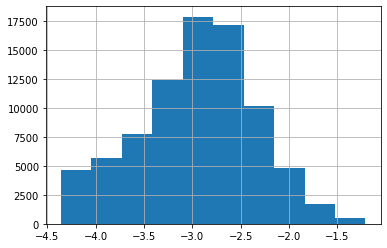

In [ ]:
train.log_target.hist()

In [ ]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    training_history = model.fit(
        train_emb,
        train_y,
        epochs=100,
        callbacks=[cp_callback],
        batch_size=64, 
        validation_split=0.1, 
        shuffle=True
    )

## making predictions

In [ ]:
def stretch(array):
    array = np.array([[element] * 10 for element in array])
    return array.reshape(-1)

In [ ]:
def delete_repetitions(tags):
    lst = []
    begginings = []
    for tag in tags:
        if tag[:5] not in begginings:
            lst.append(tag)
            begginings.append(tag[:5])
        
    return lst

In [ ]:
def nonspecial(text):
    text = re.sub("[^a-zA-Z0-9 ]+", "",text)
    if len(text) > 0:
        return text

In [ ]:
test_tags = test_tags.apply(lambda x: x.split('|'))
test_tags = [delete_repetitions(video) for video in test_tags]
test_tags = [[nonspecial(tag) for tag in video] for video in test_tags]
test_tags = [list(filter(lambda x: x != None, video)) for video in test_tags]

In [ ]:
MAKE_EMB = True
if MAKE_EMB:
    for i in range(251, 500):
        np.save('/content/gdrive/MyDrive/youtube/tags embeddings/em_{}'.format(i), \
                bert_model(bert_preprocess_model(reshaped_tags[1024*i : 1024*(i + 1)])) \
                ['pooled_output'].numpy())
        gc.collect()

In [ ]:
train_y = train_y[:256000]